In [1]:
import json
import os
import pickle
import re
from tqdm import tqdm
import itertools
from __future__ import print_function
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from nltk.stem.snowball import SnowballStemmer
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('dark_background')

C:\Users\saboo.Varun\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\saboo.Varun\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def read_data(filename):
    
    def in_washington(location):
        washington_words = ['Seattle','Washington','WA','Kirkland']
        washington_anti = ['DC','D.C','D.C.']
        if (any(word in location for word in washington_words) and 
            not any(word in location for word in washington_anti)):
            return True
        return False
            
    def in_massachusetts(location):
        massachusetts_words = ['MA','Massachusetts','Boston','Worcester','Springfield',
                               'Lowell','Arlington','Bedford','Brockton','Quincy','Lynn',
                               'Northampton','Cambridge']
        massachusetts_anti = ['Ohio']
            
        if (any(word in location for word in massachusetts_words) and 
            not any(word in location for word in massachusetts_anti)):
            return True
        return False        
        
    data = []
    labels = []
    with open(filename,'r') as fp:
        tweet_count = 1348767
        for index,line in tqdm(enumerate(fp),total=tweet_count):
            entry = json.loads(line)
            location = entry['tweet']['user']['location']
            if(in_washington(location)):
                data.append(entry['tweet']['text'])
                labels.append(1)
            elif(in_massachusetts(location)):
                data.append(entry['tweet']['text'])
                labels.append(-1)
    print(data[:20])
    return preprocess_tweets(data),labels

def preprocess_tweets(data):
    processed_tweets = []
    emoticons_str = r"""
        (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
        )"""
    html_str = r'<[^>]+>'
    url_str = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
    numbers_str = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
    mention_str = r'(?:@[\w_]+)'
    hash_tag_str = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
    regex_str = [
        emoticons_str, html_str,mention_str,
        url_str, numbers_str,hash_tag_str,r'(?:[\w]+)',r"(?:[a-z][a-z'\-_]+[a-z])",
    ]

    delete_str = [
        emoticons_str, html_str,mention_str,
        url_str, numbers_str, r'RT'
    ]

    tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
    emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
    delete_re = re.compile(r'('+'|'.join(delete_str)+')', re.VERBOSE | re.IGNORECASE)

    def tokenize(s):
        return tokens_re.findall(s)

    def preprocess(s, lowercase=True):
        tokens = tokenize(s)
        if lowercase:
            tokens = [token.lower() for token in tokens if not delete_re.search(token)]
        return ' '.join(tokens)

    for tweet in data:
        processed_tweets.append(preprocess(tweet))
    return processed_tweets

def init_params():
    stemmer = SnowballStemmer('english')
    analyzer = CountVectorizer().build_analyzer()
    vectorizer = CountVectorizer(stop_words='english',
                                 min_df=2, max_df=0.95, analyzer=stem_words)
    tfidf_transformer = TfidfTransformer(norm='l2', sublinear_tf=True)
    return [stemmer,analyzer,vectorizer,tfidf_transformer]

def stem_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def get_tfidf(vectorizer,tfidf_transformer,data,isTraining=True):
    if(isTraining):
        count_data = vectorizer.fit_transform(data)
        tfidf_data = tfidf_transformer.fit_transform(count_data)
    else:
        count_data = vectorizer.transform(data)
        tfidf_data = tfidf_transformer.transform(count_data)        
    return tfidf_data

In [7]:
def get_data(filename=None,dataset='train',precomputed=True):
    if(filename is None):
        precomputed = True
    if(not precomputed):
        if not os.path.exists(os.path.join('data',dataset,'part2')):
            os.makedirs(os.path.join('data',dataset,'part2'))
        tweets,labels = read_data(os.path.join('data',dataset,filename))
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'wb')) as fp:
            pickle.dump([tweets,labels],fp,protocol=2)
    else:
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'rb')) as fp:
            tweets,labels = pickle.load(fp)
    return tweets,labels

print('Loading #superbowl tweets')
tweets,labels = get_data('tweets_#superbowl.txt',precomputed=True)
print('Number of tweets =',len(tweets))

Loading #superbowl tweets
Number of tweets = 46794


In [8]:
load_tfidf_data = True
target_names = ['Washington','Massachusetts']
pickleFile = os.path.join('data','train','part2','tfidf.pkl')

if(not load_tfidf_data):
    print('Computing TF-IDF matrix')
    stemmer,analyzer,vectorizer,tfidf_transformer = init_params()
    tweets_train,tweets_test,train_labels,test_labels = train_test_split(tweets,labels,
                                                                     test_size=0.15,
                                                                     random_state=42)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    tweets_train = get_tfidf(vectorizer,tfidf_transformer,tweets_train)
    tweets_test = get_tfidf(vectorizer,tfidf_transformer,tweets_test,isTraining=False)
 
    with open(pickleFile,'wb') as fp:
        pickle.dump({'tweets_train':tweets_train,'tweets_test':tweets_test,
                     'train_labels':train_labels,'test_labels':test_labels},fp)
else:
    with open(pickleFile,'rb') as fp:
        pickle_data = pickle.load(fp)
        tweets_train = pickle_data['tweets_train']
        tweets_test = pickle_data['tweets_test']
        train_labels = pickle_data['train_labels']
        test_labels = pickle_data['test_labels']
        
print('Shape of Training Data =', tweets_train.shape)
print('Shape of Testing Data =', tweets_test.shape)
print('# of Washington Labels in training=', sum(train_labels==1))
print('# of Massachusetts Labels in training=', sum(train_labels==-1))
print('# of Washington Labels in testing=', sum(test_labels==1))
print('# of Massachusetts Labels in testing=', sum(test_labels==-1))

Shape of Training Data = (39774, 8655)
Shape of Testing Data = (7020, 8655)
# of Washington Labels in training= 17213
# of Massachusetts Labels in training= 22561
# of Washington Labels in testing= 3050
# of Massachusetts Labels in testing= 3970


In [9]:
def get_lsi(data,dim,lsi=None,train=True):
    if(train):
        lsi = TruncatedSVD(n_components=dim)
        lsi_data = lsi.fit_transform(data)
    else:
        lsi_data = lsi.transform(data)
    return lsi,lsi_data

def get_nmf(data,dim,nmf=None,train=True):
    if(train):
        nmf = NMF(n_components=dim, init='random', random_state=42)
        nmf_data = nmf.fit_transform(data)
    else:
        nmf_data = nmf.transform(data)
    return nmf,nmf_data

def reduced_dimension(dim_reduce,train_data=None,test_data=None,precomputed=False,dim=100):
    pickleFile = os.path.join('data','train','part2',dim_reduce+'.pkl')
    if(precomputed):
        with open(pickleFile,'rb') as fp:
            dim_reduce_dict = pickle.load(fp)
        model = dim_reduce_dict['model']
        train_data = dim_reduce_dict['train']
        test_data = dim_reduce_dict['test']
    else:
        if(dim_reduce == 'lsi'):
            method = get_lsi
        else:
            method = get_nmf
        model,train_data = method(train_data,dim)
        _,test_data = method(test_data,dim,model,train=False)
        with open(pickleFile,'wb') as fp:
            pickle.dump({'model':model,'train':train_data,'test':test_data},fp)
    return train_data,test_data

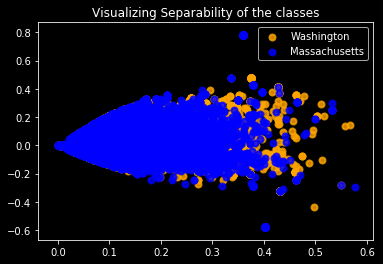

In [10]:
def visualize(data,labels,target_names):
    #Visualization
    colors = ['orange', 'blue']
    for color, i, target_name in zip(colors, [1,-1], target_names):
        plt.scatter(data[labels == i, 0], data[labels == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
    plt.legend(loc='best', labels=target_names)
    plt.title('Visualizing Separability of the classes')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_roc_curve(fpr,tpr,algo):
    roc_auc = metrics.auc(fpr,tpr)
    fig=plt.figure(figsize=(8,8))
    plt.title(''.join(['ROC - ',algo]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
target_names = ['Washington','Massachusetts']
_,visualize_data = get_lsi(tweets_train,2)    
visualize(visualize_data,train_labels,target_names)

In [11]:
X_train,X_test = reduced_dimension('lsi',tweets_train,tweets_test,precomputed=True,dim=100)

In [17]:
def classify(model,X_train,X_test,y_train,y_test,classifier):
    target_names = ['Washington','Massachusetts']
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test))
    print('Precision of model =',metrics.precision_score(y_pred,y_test,average='macro'))
    print('Recall of model =',metrics.recall_score(y_pred,y_test,average='macro'))
    cfm = metrics.confusion_matrix(y_pred,y_test)
    plot_confusion_matrix(cfm,target_names)
    y_pred = model.predict_proba(X_test)
    fpr,tpr,_ = metrics.roc_curve(y_test, y_pred[:,1])
    plot_roc_curve(fpr,tpr,classifier)

##### Naive Bayes - Bernoulli

Accuracy of model = 0.70584045584
Precision of model = 0.689701862328
Recall of model = 0.704349348908


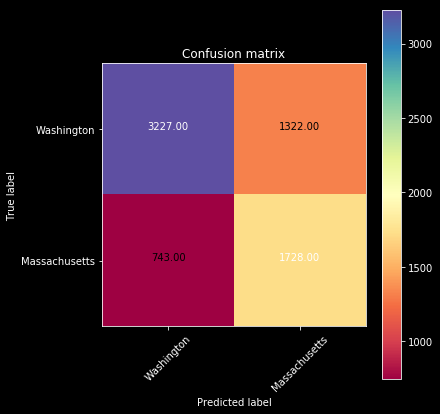

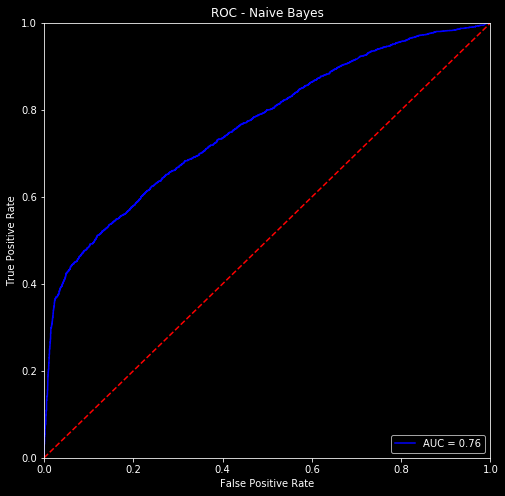

In [18]:
classify(BernoulliNB(),X_train,X_test,train_labels,test_labels,'Naive Bayes')

##### SVM

Accuracy of model = 0.772364672365
Precision of model = 0.744377090474
Recall of model = 0.81654514949


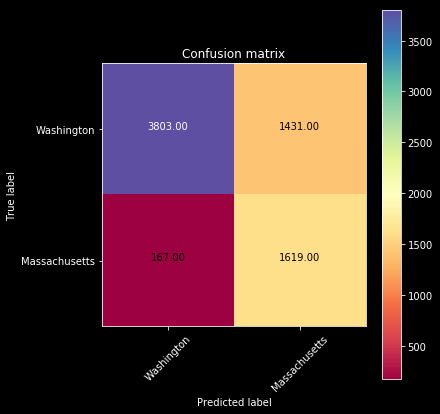

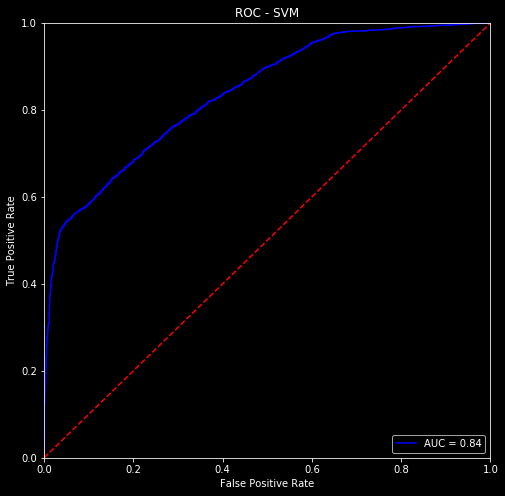

In [23]:
classify(svm.SVC(C=10,probability=True),X_train,X_test,train_labels,test_labels,'SVM')

##### AdaBoost

Accuracy of model = 0.762820512821
Precision of model = 0.740839492918
Recall of model = 0.781408223703


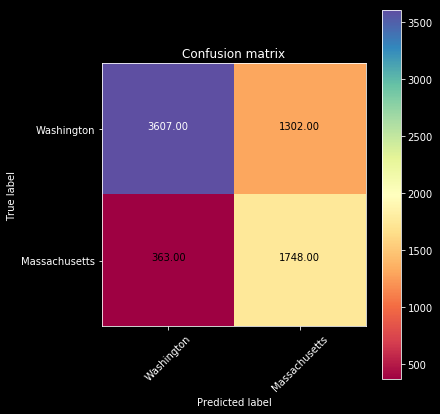

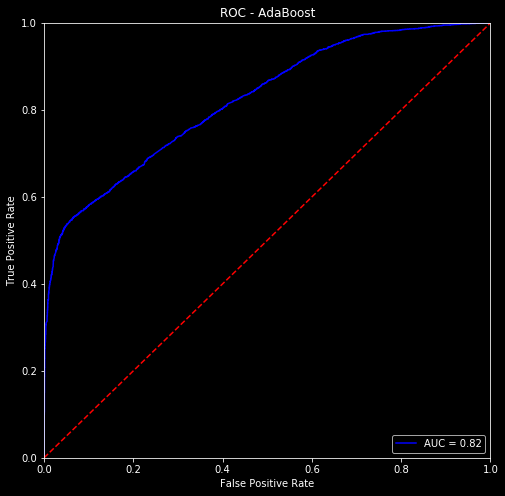

In [21]:
classify(AdaBoostClassifier(), X_train,X_test,train_labels,test_labels,'AdaBoost')

##### Random Forest

Accuracy of model = 0.76339031339
Precision of model = 0.735682784821
Recall of model = 0.80273216531


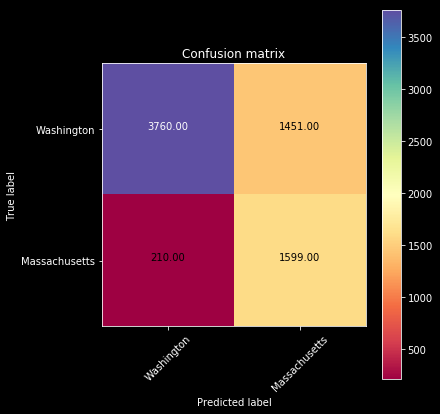

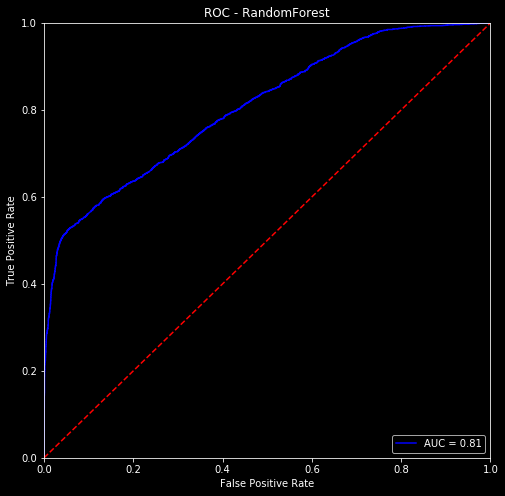

In [20]:
classify(RandomForestClassifier(max_depth=5, n_estimators=50)
         ,X_train,X_test,train_labels,test_labels,'RandomForest')

##### Neural Network

Accuracy of model = 0.746581196581
Precision of model = 0.73947433621
Recall of model = 0.742470063507


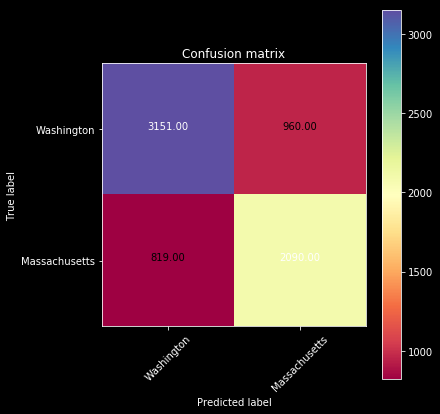

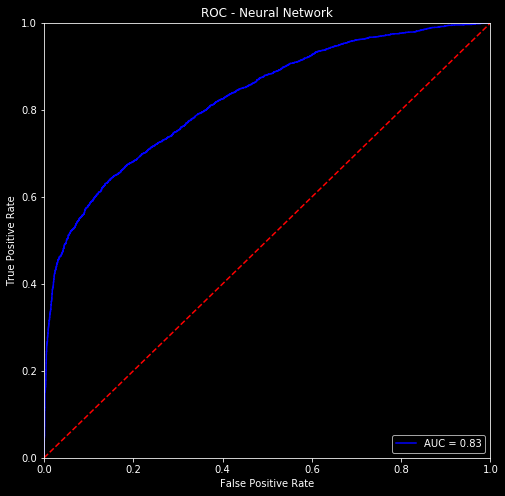

In [22]:
classify(MLPClassifier(hidden_layer_sizes=[100,100],activation='relu',batch_size=256),
         X_train,X_test,train_labels,test_labels,'Neural Network')

##### Logistic Regression

Accuracy of model = 0.776780626781
Precision of model = 0.750636742784
Recall of model = 0.814167097743


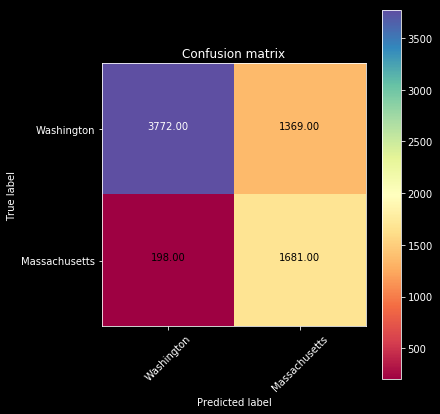

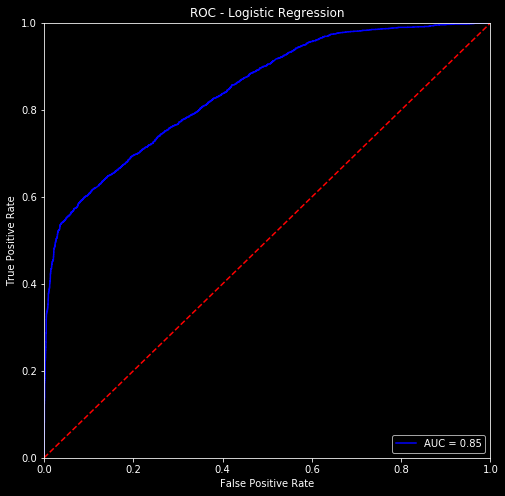

In [19]:
classify(LogisticRegression(),X_train,X_test,train_labels,test_labels,'Logistic Regression')

In [25]:
def get_accuracy(model,X_train,X_test,y_train,y_test):
    target_names = ['Washington','Massachusetts']
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics.accuracy_score(y_pred,y_test)*100

dims = [20*i for i in range(1,11)]
accuracies = {'Logistic Regression':[],'Random Forest':[],'SVM':[],}

for d in dims:
    X_train,X_test = reduced_dimension('lsi',tweets_train,tweets_test,precomputed=False,dim=d)
    accuracies['Logistic Regression'].append(get_accuracy(LogisticRegression(),
                                                          X_train,X_test,
                                                          train_labels,test_labels))
    accuracies['Random Forest'].append(get_accuracy(RandomForestClassifier(max_depth=5, n_estimators=50)
         ,X_train,X_test,train_labels,test_labels))
    accuracies['SVM'].append(get_accuracy(svm.SVC(),X_train,X_test,train_labels,test_labels))
                            
        

AttributeError: 'module' object has no attribute 'fig'

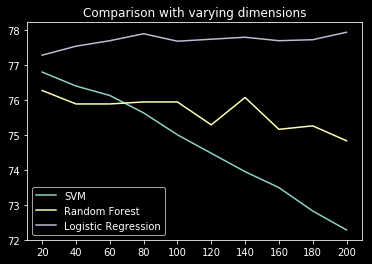

In [30]:
def plot_comparison(results):
    fig = plt.figure()
    plt.title('Comparison with varying dimensions')
    for key,value in results.items():
        plt.plot(value,label=key)
        plt.xticks(range(len(dims)),dims)
    plt.legend(loc='best')
    plt.show()
plot_comparison(accuracies)